In [1]:
# # Povezivanje sa Drive-om

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import glob
import keras
import shutil
#import tflearn
import tensorflow as tf

from PIL import Image
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
#from tflearn.data_preprocessing import ImagePreprocessing
from tensorflow.keras.utils import plot_model

In [3]:
# Konvolucioni blok
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    #x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.Activation("relu")(x)

    return x

# Enkoder
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)
    return x, p

# Dekoder 
def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    #x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# U-net arhiterktura
def build_unet(input_shape, encoder = False):
    inputs = tf.keras.layers.Input(input_shape)

    s1, p1 = encoder_block(inputs, 4)
    s2, p2 = encoder_block(p1, 16)
    s3, p3 = encoder_block(p2, 32)
    s4, p4 = encoder_block(p3, 512)
    #s5, p5 = encoder_block(p4, 128)

    b1 = conv_block(p4, 1024)
    d4 = tf.keras.layers.Flatten()(b1)
    outputs_2 = tf.keras.layers.Dense(1, activation = 'sigmoid')(d4)

    #d1 = decoder_block(b1, s5, 128)
    d2 = decoder_block(b1, s4, 512)
    d3 = decoder_block(d2, s3, 256)
    d4 = decoder_block(d3, s2, 128)
    d5 = decoder_block(d4, s1, 64)
    
    d6 = tf.keras.layers.Flatten()(d5)
    outputs_1 = tf.keras.layers.Dense(1, activation='sigmoid')(d6)
    

    if not encoder:
      model = tf.keras.models.Model(inputs, outputs_1, name="U_Net")
      return model

    else: 
      model = tf.keras.models.Model(inputs, outputs_2, name="U_Net_encoder")
      return model

In [4]:
input_shape = (224, 224, 3)

model_1 = build_unet(input_shape)
model_2 = build_unet(input_shape, encoder=True)

#run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
# loss = categorical_crossentropy
model_1.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['binary_accuracy'])#,options = run_opts)
#model_2.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['binary_accuracy'])#,options = run_opts)

model_1.summary()
#plot_model(model, 'model.png', show_shapes=True)
#model.save('model.h5')
#plot_model(model_1, 'model_1.png', show_shapes=False)
#plot_model(model_2, 'model_2.png', show_shapes=False)
      # save the encoder to file


Model: "U_Net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 4)       112       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 4)      16        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 4)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 4)       148       
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 4)      16        
 hNormalization)                                             

In [5]:
# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
# history = model.fit_generator(generator=train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=validation_generator,
#                     validation_steps=STEP_SIZE_VALID,
#                     epochs=20
# )

# Učitavanje slika

os.chdir('/content/drive/MyDrive/Tamara_Fakultet_AI_NM/Binarno_balansirano')

img_size = (224, 224)
batch_size = 10
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        'Train',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        'Test',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary'
        )

validation_generator = val_datagen.flow_from_directory(
        'Validation',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary'
        )


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
history  = model_1.fit(train_generator,
                     #steps_per_epoch=STEP_SIZE_TRAIN,
                     validation_data=validation_generator,
                     #validation_steps=STEP_SIZE_VALID,
                     epochs=50)



Found 3908 images belonging to 2 classes.
Found 1448 images belonging to 2 classes.
Found 1376 images belonging to 2 classes.
Epoch 1/50
391/391 [==============================] - 140s 337ms/step - loss: 2.8787 - binary_accuracy: 0.5026 - val_loss: 0.6931 - val_binary_accuracy: 0.5174
Epoch 2/50
391/391 [==============================] - 125s 320ms/step - loss: 0.6923 - binary_accuracy: 0.5013 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 3/50
391/391 [==============================] - 125s 320ms/step - loss: 0.6925 - binary_accuracy: 0.5148 - val_loss: 0.6989 - val_binary_accuracy: 0.5283
Epoch 4/50
391/391 [==============================] - 125s 320ms/step - loss: 0.6928 - binary_accuracy: 0.5251 - val_loss: 0.6929 - val_binary_accuracy: 0.5240
Epoch 5/50
391/391 [==============================] - 125s 320ms/step - loss: 0.6908 - binary_accuracy: 0.5427 - val_loss: 0.7019 - val_binary_accuracy: 0.5443
Epoch 6/50
391/391 [==============================] - 125s 320ms/step - lo

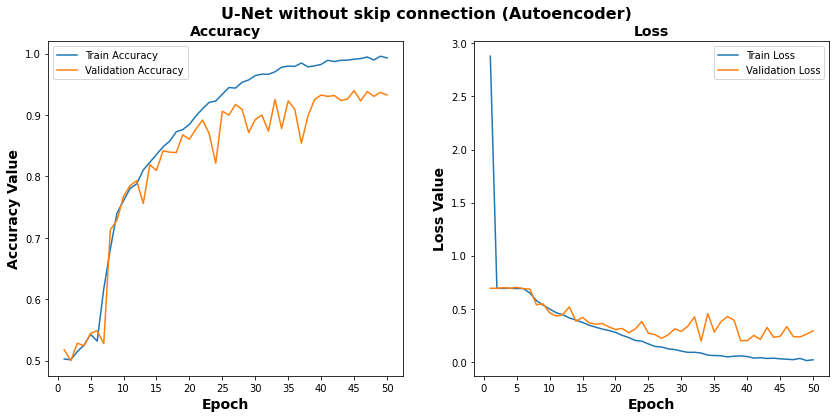

In [6]:
from posixpath import expandvars
import matplotlib.pyplot as plt
import numpy as np

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
t = f.suptitle('U-Net without skip connection (Autoencoder)', fontsize=16,fontweight='bold')
f.subplots_adjust(top=0.9, wspace=0.2)

max_epoch = len(history.history['binary_accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['binary_accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_binary_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, max_epoch, 5))
ax1.set_ylabel('Accuracy Value',fontsize=14,fontweight='bold')
ax1.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax1.set_title('Accuracy', fontsize=14,fontweight='bold')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, max_epoch, 5))
ax2.set_ylabel('Loss Value',fontsize=14,fontweight='bold')
ax2.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax2.set_title('Loss',fontsize=14,fontweight='bold')
l2 = ax2.legend(loc="best")

In [7]:
#y_pred = model_1.predict(test_generator)
#y_pred.reshape(-1)
#print(y_pred)
from sklearn.metrics import confusion_matrix 

y_pred = model_2.predict(test_generator)


[[2.7747825e-08]
 [8.0565400e-03]
 [9.9981707e-01]
 ...
 [1.0000000e+00]
 [1.7032357e-01]
 [4.9895770e-03]]


In [10]:
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(y_pred)

[[0.]
 [0.]
 [1.]
 ...
 [1.]
 [0.]
 [0.]]


In [11]:
nulta = 0
prva = 0
for i in range(len(y_pred)):
  if y_pred[i]==0:
    nulta += 1
  elif y_pred[i]==1:
    prva += 1
  i+=1

print((nulta))
print((prva))


755
693


In [9]:
confusion_matrix_test = confusion_matrix(test_generator.classes, y_pred)
print(confusion_matrix_test)